In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)

import modules.utils as utils

## Print data

In [24]:
path_data = 'data/uxy18_T10.nc'
#ds_init = xr.open_dataset(f'../data/external_data/ClimateData/{state_name}.nc')
ds_init = xr.open_dataset(path_data)
df_init = ds_init.to_dataframe()
#len(df_init.index.levels[3])

In [25]:
df_init.reset_index(inplace=True)
df_init

,t,z,y,x,uxy18
0,0,0,0,0,14.890
1,0,0,0,1,14.930
2,0,0,0,2,14.831
3,0,0,0,3,14.711
4,0,0,0,4,14.798
...,...,...,...,...,...
524283,0,1,511,507,14.870
524284,0,1,511,508,14.816
524285,0,1,511,509,14.848
524286,0,1,511,510,14.786


In [21]:
couche0 = df_init[df_init['z']==0].drop(columns=['t','x','y','z'])
couche0.head()

,sxy18
0,0.13189
1,0.13021
2,0.12685
3,0.12452
4,0.12587


In [6]:
arr = couche0.to_numpy()
arr.shape

(262144, 1)

In [7]:
arr2 = arr.reshape(512, 512)

In [9]:
arr2.shape

(512, 512)

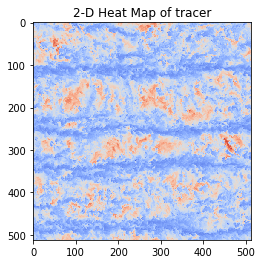

In [10]:
plt.imshow(arr2 , cmap = 'coolwarm' , interpolation = 'nearest' )
  
plt.title( "2-D Heat Map of tracer" )
plt.show()

In [11]:
def print_one_alt(path_data,color):
    ds_init = xr.open_dataset(path_data)
    df_init = ds_init.to_dataframe()
    df_init.reset_index(inplace=True)
    couche0 = df_init[df_init['z']==0].drop(columns=['t','x','y','z'])
    arr = couche0.to_numpy()
    arr2 = arr.reshape(512, 512)
    plt.imshow(arr2 , cmap = color , interpolation = 'nearest' )
    plt.title( "2-D Heat Map of tracer" )
    plt.show()

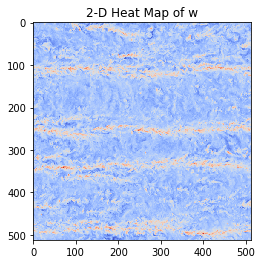

In [2]:
utils.print_one_alt('data/wxy18_T10.nc','w','coolwarm')

## Get all data and stack altitude layers

In [9]:
path_data1 = 'data/sxy18_T10.nc'
ds_init = xr.open_dataset(path_data1)
df_init = ds_init.to_dataframe()
lengths = [len(df_init.index.levels[i]) for i in range(4)]

In [11]:
arr1 = df_init.values.reshape(lengths[0],lengths[1],lengths[2],lengths[3])  # arr[t][z][y][x]  #.swapaxes(2,3) ?
arr1.shape

(1, 2, 512, 512)

In [12]:
path_data2 = 'data/sxy19_T10.nc'
ds_init2 = xr.open_dataset(path_data2)
df_init2 = ds_init2.to_dataframe()
lengths2 = [len(df_init2.index.levels[i]) for i in range(4)]
arr2 = df_init2.values.reshape(lengths2[0],lengths2[1],lengths2[2],lengths2[3])

In [13]:
arr_tot = np.concatenate((arr1,arr2),axis=1)
arr_tot.shape

(1, 4, 512, 512)

In [48]:
# path joining version for other paths
DIR = 'data'
print(os.listdir(DIR))
#print(len([name for name in os.listdir(DIR) if os.path.isname(os.path.join(DIR, name))]))

['uxy18_T10.nc', 'thetaxy19_T10.nc', 'vxy19_T10.nc', 'wxy18_T10.nc', 'sxy19_T10.nc', 'uxy19_T10.nc', 'vxy18_T10.nc', 'thetaxy18_T10.nc', 'sxy18_T10.nc', 'wxy19_T10.nc']


In [64]:
# number of files in a directory that contain a certain string
print(len([file for file in os.listdir(DIR) if  file.__contains__("sxy") and file.__contains__("_T10.nc")]))

2


In [65]:
import re

pattern = '(\d+)'
string = 'sxy19_T10.nc'
result = re.split(pattern, string)
print(result)

['sxy', '19', '_T', '10', '.nc']


In [86]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)',text) ]
my_list =['sxy19_T10.nc', 'sxy18_T10.nc', 'sxy20_T9.nc']
my_list.sort(key=natural_keys)
print(my_list, natural_keys('sxy19_T10.nc'))

['sxy18_T10.nc', 'sxy19_T10.nc', 'sxy20_T9.nc'] ['sxy', 19, '_T', 10, '.nc']


In [77]:
def concatenate_alt(dir, variable, t):
    '''
    ## Description
    Concatenate all files in a directory over the altitude axis for a given variable and a given instant.
    File name format : '{variable}xy{alt}_T{t}.nc'.

    ## Parameters
    - dir (str): directory where the files are stored
    - variable (str) : name of the variable to concatenate
    - t (int) : time instant to concatenate
    '''
    files = [name for name in os.listdir(dir) if  name.__contains__(f"{variable}xy") and name.__contains__(f"_T{t}.nc")]
    lz = len(files)

    assert lz!=0, "there is no file for this variable and time instant"
    files.sort()

    #initialize array
    path_data = os.path.join(dir, files[0])
    ds_init = xr.open_dataset(path_data)
    df_init = ds_init.to_dataframe()
    lengths = [len(df_init.index.levels[i]) for i in range(4)]
    arr = df_init.values.reshape(lengths[0],lengths[1],lengths[2],lengths[3])

    # concatenate
    for z in range(1,lz):
        path_data = os.path.join(dir, files[z])
        ds_init = xr.open_dataset(path_data)
        df_init = ds_init.to_dataframe()
        lengths = [len(df_init.index.levels[i]) for i in range(4)]
        arr2 = df_init.values.reshape(lengths[0],lengths[1],lengths[2],lengths[3])
        arr = np.concatenate((arr,arr2),axis=1)

    return arr

In [119]:
concatenate_alt('data','theta',10)[0].shape

(4, 512, 512)

In [98]:
files = [name for name in os.listdir('data') if  name.__contains__(f"xy")]
temp = [int(re.split('(\d+)', name)[3]) for name in files]
times = [t for n, t in enumerate(temp) if t not in temp[:n]]
times.sort()
times

[10, 11]

In [122]:
def concatenate_time(dir,variable):
    '''
    ## Description
    Concatenate all files in a directory over the time axis for a given variable.
    File name format : '{variable}xy{alt}_T{t}.nc'.

    ## Parameters
    - dir (str): directory where the files are stored
    - variable (str) : name of the variable to concatenate
    '''
    files = [name for name in os.listdir(dir) if  name.__contains__(f"{variable}xy")]
    temp = [int(re.split('(\d+)', name)[3]) for name in files]
    times = [t for n, t in enumerate(temp) if t not in temp[:n]]
    times.sort()

    tot_arr = concatenate_alt(dir,variable,times[0])

    for t in range(1,len(times)) :
        t_arr = concatenate_alt(dir,variable,times[t])
        assert tot_arr.shape[1]==t_arr.shape[1], "total altitude is not equal for every instant"
        tot_arr = np.concatenate((tot_arr,t_arr),axis=0)
        
    return tot_arr

In [123]:
concatenate_time('data','s').shape

(2, 4, 512, 512)